# TempNet Training & Comparison

Train four CNN-LSTM TempNet variants (sequence length 2-5) using fast-loading datasets, MAE loss, and outputs aligned with `MICROnet.ipynb`.

In [1]:
import json
import os
import random
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from lasernet.model.CNN_LSTM import CNN_LSTM
from lasernet.micronet.dataset.fast_loading import FastSliceSequenceDataset
from lasernet.micronet.dataset.preprocess_data import save_preprocessed_data
from lasernet.utils import plot_losses, visualize_prediction

/zhome/b0/7/168550/Github/LASERNet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reproducibility

In [2]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

GLOBAL_SEED = 42
set_seed(GLOBAL_SEED)
print(f"Seed set to {GLOBAL_SEED} across Python/NumPy/PyTorch")

Seed set to 42 across Python/NumPy/PyTorch


## Global Configuration

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 80
LEARNING_RATE = 1e-3
PATIENCE = 12
MIN_DELTA = 1e-4
TARGET_OFFSET = 1
PLANE = "xz"
SPLIT_RATIO = "10,6,8"
split_parts = [int(x) for x in SPLIT_RATIO.split(",")]
split_sum = sum(split_parts)
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = [part / split_sum for part in split_parts]

OUTPUT_ROOT = Path("TEMPnet_output")
OUTPUT_ROOT.mkdir(exist_ok=True)

PRED_TIMESTEP = 23
PRED_SLICE_INDEX = 47

print(f"Device: {DEVICE.type}")
print(f"Output root: {OUTPUT_ROOT.resolve()}")
print(f"Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}, LR: {LEARNING_RATE}")
print(f"Split ratios (train/val/test): {TRAIN_RATIO:.2f}/{VAL_RATIO:.2f}/{TEST_RATIO:.2f}")
print(f"Prediction target → timestep {PRED_TIMESTEP}, slice index {PRED_SLICE_INDEX}")

Device: cuda
Output root: /zhome/b0/7/168550/Github/LASERNet/TEMPnet_output
Epochs: 80, Batch size: 16, LR: 0.001
Split ratios (train/val/test): 0.42/0.25/0.33
Prediction target → timestep 23, slice index 47


## Fast Dataset Setup

In [4]:
def ensure_preprocessed_data() -> Path:
    """Ensure fast-loading tensors exist, running preprocessing once if needed."""
    blackhole = os.environ.get("BLACKHOLE")
    if not blackhole:
        raise RuntimeError("BLACKHOLE environment variable is not set.")

    data_dir = Path(blackhole) / "data"
    processed_dir = Path(blackhole) / "processed" / "data"
    processed_dir.mkdir(parents=True, exist_ok=True)

    required = ["coordinates.pt", "temperature.pt", "mask.pt"]
    missing = [fname for fname in required if not (processed_dir / fname).exists()]

    if missing:
        print("Preprocessed tensors missing → running preprocessing once...")
        print(f"  Source data: {data_dir}")
        print(f"  Output dir : {processed_dir}")
        save_preprocessed_data(data_dir=data_dir, output_dir=processed_dir, downsample_factor=2)
        print("✓ Preprocessing complete")
    else:
        print("✓ Preprocessed tensors found")

    return processed_dir


def load_json_if_exists(path: Path) -> Dict:
    if path.exists():
        with open(path, "r", encoding="utf-8") as fp:
            return json.load(fp)
    return {}


def save_json(path: Path, payload: Dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as fp:
        json.dump(payload, fp, indent=2)


def build_dataloaders(seq_length: int) -> Tuple[DataLoader, DataLoader, DataLoader, Dict[str, int]]:
    dataset_kwargs = dict(
        plane=PLANE,
        sequence_length=seq_length,
        target_offset=TARGET_OFFSET,
        processed_dir=PROCESSED_DIR,
        train_ratio=TRAIN_RATIO,
        val_ratio=VAL_RATIO,
        test_ratio=TEST_RATIO,
    )

    train_dataset = FastSliceSequenceDataset(split="train", **dataset_kwargs)
    val_dataset = FastSliceSequenceDataset(split="val", **dataset_kwargs)
    test_dataset = FastSliceSequenceDataset(split="test", **dataset_kwargs)

    loader_kwargs = dict(batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    train_loader = DataLoader(train_dataset, **loader_kwargs)
    val_loader = DataLoader(val_dataset, **loader_kwargs)
    test_loader = DataLoader(test_dataset, **loader_kwargs)

    metadata = dict(
        sequence_length=seq_length,
        train_samples=len(train_dataset),
        val_samples=len(val_dataset),
        test_samples=len(test_dataset),
        num_slices=len(train_dataset.slice_coords),
        plane=PLANE,
    )
    return train_loader, val_loader, test_loader, metadata


def evaluate_split(model: CNN_LSTM, loader: DataLoader, criterion: nn.Module) -> Dict[str, float]:
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    sample_count = 0

    with torch.no_grad():
        for batch in loader:
            context = batch["context"].float().to(DEVICE)
            target = batch["target"].float().to(DEVICE)
            mask = batch["target_mask"].to(DEVICE).unsqueeze(1).bool()

            prediction = model(context)
            if mask.sum() == 0:
                continue

            masked_pred = prediction[mask]
            masked_target = target[mask]
            loss = criterion(masked_pred, masked_target)

            batch_size = context.size(0)
            running_loss += loss.item() * batch_size
            running_mae += torch.mean(torch.abs(masked_pred - masked_target)).item() * batch_size
            sample_count += batch_size

    denom = max(sample_count, 1)
    return {"loss": running_loss / denom, "mae": running_mae / denom}


PROCESSED_DIR = ensure_preprocessed_data()
print(f"Fast tensors located at {PROCESSED_DIR}")

✓ Preprocessed tensors found
Fast tensors located at /dtu/blackhole/06/168550/processed/data


## Model Configurations

In [5]:
MODEL_CONFIGS: List[Dict[str, int | str]] = [
    {
        "id": 1,
        "name": "1_TEMPnet_cnn_lstm_seq2_MAEloss",
        "seq_length": 2,
        "lstm_layers": 1,
    },
    {
        "id": 2,
        "name": "2_TEMPnet_cnn_lstm_seq3_MAEloss",
        "seq_length": 3,
        "lstm_layers": 1,
    },
]

print(f"Configured {len(MODEL_CONFIGS)} models:")
for cfg in MODEL_CONFIGS:
    print(f"  {cfg['id']:>2}: {cfg['name']} (seq_len={cfg['seq_length']})")

Configured 2 models:
   1: 1_TEMPnet_cnn_lstm_seq2_MAEloss (seq_len=2)
   2: 2_TEMPnet_cnn_lstm_seq3_MAEloss (seq_len=3)


## Training Utilities


=== Running 1_TEMPnet_cnn_lstm_seq2_MAEloss (seq_len=2) ===
Loading train data from /dtu/blackhole/06/168550/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: train
  Plane: xz
  Sequence length: 2
  Target offset: 1
  Timesteps: 10 (indices 0-9)
  Valid sequences: 7
  Slices: 94
  Total samples: 658

Loading val data from /dtu/blackhole/06/168550/processed/data...


Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: val
  Plane: xz
  Sequence length: 2
  Target offset: 1
  Timesteps: 6 (indices 10-15)
  Valid sequences: 3
  Slices: 94
  Total samples: 282

Loading test data from /dtu/blackhole/06/168550/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: test
  Plane: xz
  Sequence length: 2
  Target offset: 1
  Timesteps: 8 (indices 16-23)
  Valid sequences: 5
  Slices: 94
  Total samples: 470



Seq2 Epoch 1/80 [train]:   0%|                                                                                                                                                      | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 1/80 [train]:   2%|███▍                                                                                                                                          | 1/42 [00:01<00:41,  1.01s/it]

Seq2 Epoch 1/80 [train]:   7%|██████████▏                                                                                                                                   | 3/42 [00:01<00:11,  3.27it/s]

Seq2 Epoch 1/80 [train]:  12%|████████████████▉                                                                                                                             | 5/42 [00:01<00:06,  5.65it/s]

Seq2 Epoch 1/80 [train]:  17%|███████████████████████▋                                                                                                                      | 7/42 [00:01<00:04,  7.97it/s]

Seq2 Epoch 1/80 [train]:  21%|██████████████████████████████▍                                                                                                               | 9/42 [00:01<00:03, 10.14it/s]

Seq2 Epoch 1/80 [train]:  29%|████████████████████████████████████████▎                                                                                                    | 12/42 [00:01<00:02, 13.30it/s]

Seq2 Epoch 1/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 14/42 [00:01<00:01, 14.36it/s]

Seq2 Epoch 1/80 [train]:  38%|█████████████████████████████████████████████████████▋                                                                                       | 16/42 [00:01<00:01, 15.39it/s]

Seq2 Epoch 1/80 [train]:  48%|███████████████████████████████████████████████████████████████████▏                                                                         | 20/42 [00:01<00:01, 20.59it/s]

Seq2 Epoch 1/80 [train]:  57%|████████████████████████████████████████████████████████████████████████████████▌                                                            | 24/42 [00:02<00:00, 24.73it/s]

Seq2 Epoch 1/80 [train]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 28/42 [00:02<00:00, 28.01it/s]

Seq2 Epoch 1/80 [train]:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 32/42 [00:02<00:00, 30.27it/s]

Seq2 Epoch 1/80 [train]:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 36/42 [00:02<00:00, 31.69it/s]

Seq2 Epoch 1/80 [train]:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 40/42 [00:02<00:00, 33.13it/s]

Epoch 001 | train=240.2315 | val=65.7344 | train_mae=240.2315 | val_mae=65.7344
  → New best checkpoint saved


Seq2 Epoch 2/80 [train]:   0%|                                                                                                                                                      | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 2/80 [train]:   5%|██████▊                                                                                                                                       | 2/42 [00:00<00:02, 18.54it/s]

Seq2 Epoch 2/80 [train]:  10%|█████████████▌                                                                                                                                | 4/42 [00:00<00:02, 18.11it/s]

Seq2 Epoch 2/80 [train]:  14%|████████████████████▎                                                                                                                         | 6/42 [00:00<00:02, 17.36it/s]

Seq2 Epoch 2/80 [train]:  19%|███████████████████████████                                                                                                                   | 8/42 [00:00<00:01, 17.29it/s]

Seq2 Epoch 2/80 [train]:  24%|█████████████████████████████████▌                                                                                                           | 10/42 [00:00<00:01, 17.69it/s]

Seq2 Epoch 2/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 14/42 [00:00<00:01, 22.95it/s]

Seq2 Epoch 2/80 [train]:  43%|████████████████████████████████████████████████████████████▍                                                                                | 18/42 [00:00<00:00, 26.86it/s]

Seq2 Epoch 2/80 [train]:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 22/42 [00:00<00:00, 29.32it/s]

Seq2 Epoch 2/80 [train]:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 26/42 [00:01<00:00, 31.23it/s]

Seq2 Epoch 2/80 [train]:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 30/42 [00:01<00:00, 32.12it/s]

Seq2 Epoch 2/80 [train]:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 34/42 [00:01<00:00, 32.95it/s]

Seq2 Epoch 2/80 [train]:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 38/42 [00:01<00:00, 33.40it/s]

Seq2 Epoch 2/80 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 28.56it/s]

Epoch 002 | train=103.0119 | val=33.0884 | train_mae=103.0119 | val_mae=33.0884
  → New best checkpoint saved


Seq2 Epoch 3/80 [train]:   0%|                                                                                                                                                      | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 3/80 [train]:   7%|██████████▏                                                                                                                                   | 3/42 [00:00<00:01, 26.54it/s]

Seq2 Epoch 3/80 [train]:  17%|███████████████████████▋                                                                                                                      | 7/42 [00:00<00:01, 31.66it/s]

Seq2 Epoch 3/80 [train]:  26%|████████████████████████████████████▉                                                                                                        | 11/42 [00:00<00:00, 33.00it/s]

Seq2 Epoch 3/80 [train]:  36%|██████████████████████████████████████████████████▎                                                                                          | 15/42 [00:00<00:00, 33.88it/s]

Seq2 Epoch 3/80 [train]:  45%|███████████████████████████████████████████████████████████████▊                                                                             | 19/42 [00:00<00:00, 33.69it/s]

Seq2 Epoch 3/80 [train]:  55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 23/42 [00:00<00:00, 34.19it/s]

Seq2 Epoch 3/80 [train]:  64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 27/42 [00:00<00:00, 34.70it/s]

Seq2 Epoch 3/80 [train]:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 31/42 [00:00<00:00, 28.25it/s]

Seq2 Epoch 3/80 [train]:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 35/42 [00:01<00:00, 24.11it/s]

Seq2 Epoch 3/80 [train]:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 38/42 [00:01<00:00, 22.36it/s]

Seq2 Epoch 3/80 [train]:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:01<00:00, 21.74it/s]

Epoch 003 | train=96.0362 | val=67.3574 | train_mae=96.0362 | val_mae=67.3574


Seq2 Epoch 4/80 [train]:   0%|                                                                                                                                                      | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 4/80 [train]:  10%|█████████████▌                                                                                                                                | 4/42 [00:00<00:01, 36.29it/s]

Seq2 Epoch 4/80 [train]:  19%|███████████████████████████                                                                                                                   | 8/42 [00:00<00:00, 34.85it/s]

Seq2 Epoch 4/80 [train]:  29%|████████████████████████████████████████▎                                                                                                    | 12/42 [00:00<00:00, 35.17it/s]

Seq2 Epoch 4/80 [train]:  38%|█████████████████████████████████████████████████████▋                                                                                       | 16/42 [00:00<00:00, 35.52it/s]

Seq2 Epoch 4/80 [train]:  48%|███████████████████████████████████████████████████████████████████▏                                                                         | 20/42 [00:00<00:00, 29.66it/s]

Seq2 Epoch 4/80 [train]:  57%|████████████████████████████████████████████████████████████████████████████████▌                                                            | 24/42 [00:00<00:00, 24.33it/s]

Seq2 Epoch 4/80 [train]:  64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 27/42 [00:01<00:00, 22.30it/s]

Seq2 Epoch 4/80 [train]:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 30/42 [00:01<00:00, 22.16it/s]

Seq2 Epoch 4/80 [train]:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 33/42 [00:01<00:00, 20.83it/s]

Seq2 Epoch 4/80 [train]:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 36/42 [00:01<00:00, 22.13it/s]

Seq2 Epoch 4/80 [train]:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 40/42 [00:01<00:00, 25.43it/s]

Epoch 004 | train=98.5145 | val=89.7767 | train_mae=98.5145 | val_mae=89.7767


Seq2 Epoch 5/80 [train]:   0%|                                                                                                                                                      | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 5/80 [train]:  10%|█████████████▌                                                                                                                                | 4/42 [00:00<00:01, 36.33it/s]

Seq2 Epoch 5/80 [train]:  19%|███████████████████████████                                                                                                                   | 8/42 [00:00<00:00, 36.08it/s]

Seq2 Epoch 5/80 [train]:  29%|████████████████████████████████████████▎                                                                                                    | 12/42 [00:00<00:00, 31.80it/s]

Seq2 Epoch 5/80 [train]:  38%|█████████████████████████████████████████████████████▋                                                                                       | 16/42 [00:00<00:01, 25.21it/s]

Seq2 Epoch 5/80 [train]:  45%|███████████████████████████████████████████████████████████████▊                                                                             | 19/42 [00:00<00:01, 22.67it/s]

Seq2 Epoch 5/80 [train]:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 22/42 [00:00<00:00, 21.81it/s]

Seq2 Epoch 5/80 [train]:  60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 25/42 [00:01<00:00, 21.76it/s]

Seq2 Epoch 5/80 [train]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 28/42 [00:01<00:00, 20.78it/s]

Seq2 Epoch 5/80 [train]:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 32/42 [00:01<00:00, 24.21it/s]

Seq2 Epoch 5/80 [train]:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 36/42 [00:01<00:00, 27.70it/s]

Seq2 Epoch 5/80 [train]:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 40/42 [00:01<00:00, 30.04it/s]

Epoch 005 | train=95.4825 | val=91.4138 | train_mae=95.4825 | val_mae=91.4138


Seq2 Epoch 6/80 [train]:   0%|                                                                                                                                                      | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 6/80 [train]:  10%|█████████████▌                                                                                                                                | 4/42 [00:00<00:01, 36.51it/s]

Seq2 Epoch 6/80 [train]:  19%|███████████████████████████                                                                                                                   | 8/42 [00:00<00:01, 24.87it/s]

Seq2 Epoch 6/80 [train]:  26%|████████████████████████████████████▉                                                                                                        | 11/42 [00:00<00:01, 22.01it/s]

Seq2 Epoch 6/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 14/42 [00:00<00:01, 20.75it/s]

Seq2 Epoch 6/80 [train]:  40%|█████████████████████████████████████████████████████████                                                                                    | 17/42 [00:00<00:01, 20.39it/s]

Seq2 Epoch 6/80 [train]:  48%|███████████████████████████████████████████████████████████████████▏                                                                         | 20/42 [00:00<00:01, 19.87it/s]

Seq2 Epoch 6/80 [train]:  55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 23/42 [00:01<00:00, 20.99it/s]

Seq2 Epoch 6/80 [train]:  64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 27/42 [00:01<00:00, 25.21it/s]

Seq2 Epoch 6/80 [train]:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 31/42 [00:01<00:00, 28.35it/s]

Seq2 Epoch 6/80 [train]:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 35/42 [00:01<00:00, 30.86it/s]

Seq2 Epoch 6/80 [train]:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 39/42 [00:01<00:00, 32.55it/s]

Epoch 006 | train=95.1538 | val=50.0730 | train_mae=95.1538 | val_mae=50.0730


Seq2 Epoch 7/80 [train]:   0%|                                                                                                                                                      | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 7/80 [train]:   5%|██████▊                                                                                                                                       | 2/42 [00:00<00:02, 19.21it/s]

Seq2 Epoch 7/80 [train]:  10%|█████████████▌                                                                                                                                | 4/42 [00:00<00:02, 18.49it/s]

Seq2 Epoch 7/80 [train]:  14%|████████████████████▎                                                                                                                         | 6/42 [00:00<00:01, 18.50it/s]

Seq2 Epoch 7/80 [train]:  19%|███████████████████████████                                                                                                                   | 8/42 [00:00<00:01, 18.33it/s]

Seq2 Epoch 7/80 [train]:  26%|████████████████████████████████████▉                                                                                                        | 11/42 [00:00<00:01, 19.68it/s]

Seq2 Epoch 7/80 [train]:  31%|███████████████████████████████████████████▋                                                                                                 | 13/42 [00:00<00:01, 19.14it/s]

Seq2 Epoch 7/80 [train]:  36%|██████████████████████████████████████████████████▎                                                                                          | 15/42 [00:00<00:01, 18.95it/s]

Seq2 Epoch 7/80 [train]:  45%|███████████████████████████████████████████████████████████████▊                                                                             | 19/42 [00:00<00:00, 23.72it/s]

Seq2 Epoch 7/80 [train]:  55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 23/42 [00:01<00:00, 27.17it/s]

Seq2 Epoch 7/80 [train]:  64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 27/42 [00:01<00:00, 29.50it/s]

Seq2 Epoch 7/80 [train]:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 31/42 [00:01<00:00, 31.10it/s]

Seq2 Epoch 7/80 [train]:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 35/42 [00:01<00:00, 32.48it/s]

Seq2 Epoch 7/80 [train]:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 39/42 [00:01<00:00, 33.24it/s]

Epoch 007 | train=98.1208 | val=62.0726 | train_mae=98.1208 | val_mae=62.0726


Seq2 Epoch 8/80 [train]:   0%|                                                                                                                                                      | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 8/80 [train]:   5%|██████▊                                                                                                                                       | 2/42 [00:00<00:02, 18.36it/s]

Seq2 Epoch 8/80 [train]:  10%|█████████████▌                                                                                                                                | 4/42 [00:00<00:02, 17.99it/s]

Seq2 Epoch 8/80 [train]:  14%|████████████████████▎                                                                                                                         | 6/42 [00:00<00:01, 18.20it/s]

Seq2 Epoch 8/80 [train]:  19%|███████████████████████████                                                                                                                   | 8/42 [00:00<00:01, 18.18it/s]

Seq2 Epoch 8/80 [train]:  26%|████████████████████████████████████▉                                                                                                        | 11/42 [00:00<00:01, 19.83it/s]

Seq2 Epoch 8/80 [train]:  31%|███████████████████████████████████████████▋                                                                                                 | 13/42 [00:00<00:01, 19.12it/s]

Seq2 Epoch 8/80 [train]:  36%|██████████████████████████████████████████████████▎                                                                                          | 15/42 [00:00<00:01, 18.91it/s]

Seq2 Epoch 8/80 [train]:  45%|███████████████████████████████████████████████████████████████▊                                                                             | 19/42 [00:00<00:00, 23.62it/s]

Seq2 Epoch 8/80 [train]:  55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 23/42 [00:01<00:00, 27.49it/s]

Seq2 Epoch 8/80 [train]:  64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 27/42 [00:01<00:00, 29.86it/s]

Seq2 Epoch 8/80 [train]:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 31/42 [00:01<00:00, 31.73it/s]

Seq2 Epoch 8/80 [train]:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 35/42 [00:01<00:00, 33.06it/s]

Seq2 Epoch 8/80 [train]:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 39/42 [00:01<00:00, 33.89it/s]

Epoch 008 | train=95.8043 | val=73.8754 | train_mae=95.8043 | val_mae=73.8754


Seq2 Epoch 9/80 [train]:   0%|                                                                                                                                                      | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 9/80 [train]:   5%|██████▊                                                                                                                                       | 2/42 [00:00<00:02, 18.09it/s]

Seq2 Epoch 9/80 [train]:  10%|█████████████▌                                                                                                                                | 4/42 [00:00<00:02, 18.32it/s]

Seq2 Epoch 9/80 [train]:  14%|████████████████████▎                                                                                                                         | 6/42 [00:00<00:01, 18.11it/s]

Seq2 Epoch 9/80 [train]:  21%|██████████████████████████████▍                                                                                                               | 9/42 [00:00<00:01, 20.50it/s]

Seq2 Epoch 9/80 [train]:  29%|████████████████████████████████████████▎                                                                                                    | 12/42 [00:00<00:01, 19.67it/s]

Seq2 Epoch 9/80 [train]:  36%|██████████████████████████████████████████████████▎                                                                                          | 15/42 [00:00<00:01, 21.42it/s]

Seq2 Epoch 9/80 [train]:  45%|███████████████████████████████████████████████████████████████▊                                                                             | 19/42 [00:00<00:00, 25.50it/s]

Seq2 Epoch 9/80 [train]:  55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 23/42 [00:00<00:00, 28.75it/s]

Seq2 Epoch 9/80 [train]:  64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 27/42 [00:01<00:00, 30.76it/s]

Seq2 Epoch 9/80 [train]:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 31/42 [00:01<00:00, 32.45it/s]

Seq2 Epoch 9/80 [train]:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 35/42 [00:01<00:00, 33.40it/s]

Seq2 Epoch 9/80 [train]:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 39/42 [00:01<00:00, 34.16it/s]

Epoch 009 | train=94.9902 | val=60.5637 | train_mae=94.9902 | val_mae=60.5637


Seq2 Epoch 10/80 [train]:   0%|                                                                                                                                                     | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 10/80 [train]:   5%|██████▋                                                                                                                                      | 2/42 [00:00<00:02, 18.43it/s]

Seq2 Epoch 10/80 [train]:  10%|█████████████▍                                                                                                                               | 4/42 [00:00<00:02, 18.22it/s]

Seq2 Epoch 10/80 [train]:  17%|███████████████████████▌                                                                                                                     | 7/42 [00:00<00:01, 19.44it/s]

Seq2 Epoch 10/80 [train]:  21%|██████████████████████████████▏                                                                                                              | 9/42 [00:00<00:01, 18.91it/s]

Seq2 Epoch 10/80 [train]:  29%|████████████████████████████████████████                                                                                                    | 12/42 [00:00<00:01, 21.30it/s]

Seq2 Epoch 10/80 [train]:  38%|█████████████████████████████████████████████████████▎                                                                                      | 16/42 [00:00<00:00, 26.04it/s]

Seq2 Epoch 10/80 [train]:  48%|██████████████████████████████████████████████████████████████████▋                                                                         | 20/42 [00:00<00:00, 28.97it/s]

Seq2 Epoch 10/80 [train]:  57%|████████████████████████████████████████████████████████████████████████████████                                                            | 24/42 [00:00<00:00, 30.97it/s]

Seq2 Epoch 10/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 28/42 [00:01<00:00, 32.35it/s]

Seq2 Epoch 10/80 [train]:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 32/42 [00:01<00:00, 33.65it/s]

Seq2 Epoch 10/80 [train]:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 36/42 [00:01<00:00, 34.09it/s]

Seq2 Epoch 10/80 [train]:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 40/42 [00:01<00:00, 34.47it/s]

Epoch 010 | train=95.1854 | val=74.4754 | train_mae=95.1854 | val_mae=74.4754


Seq2 Epoch 11/80 [train]:   0%|                                                                                                                                                     | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 11/80 [train]:   5%|██████▋                                                                                                                                      | 2/42 [00:00<00:02, 18.80it/s]

Seq2 Epoch 11/80 [train]:  12%|████████████████▊                                                                                                                            | 5/42 [00:00<00:01, 19.78it/s]

Seq2 Epoch 11/80 [train]:  17%|███████████████████████▌                                                                                                                     | 7/42 [00:00<00:01, 19.05it/s]

Seq2 Epoch 11/80 [train]:  24%|█████████████████████████████████▎                                                                                                          | 10/42 [00:00<00:01, 21.83it/s]

Seq2 Epoch 11/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 14/42 [00:00<00:01, 26.70it/s]

Seq2 Epoch 11/80 [train]:  43%|████████████████████████████████████████████████████████████                                                                                | 18/42 [00:00<00:00, 29.51it/s]

Seq2 Epoch 11/80 [train]:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                  | 22/42 [00:00<00:00, 31.55it/s]

Seq2 Epoch 11/80 [train]:  62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                     | 26/42 [00:00<00:00, 32.72it/s]

Seq2 Epoch 11/80 [train]:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 30/42 [00:01<00:00, 33.77it/s]

Seq2 Epoch 11/80 [train]:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 34/42 [00:01<00:00, 34.36it/s]

Seq2 Epoch 11/80 [train]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 38/42 [00:01<00:00, 34.97it/s]

Epoch 011 | train=94.4518 | val=69.1154 | train_mae=94.4518 | val_mae=69.1154


Seq2 Epoch 12/80 [train]:   0%|                                                                                                                                                     | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 12/80 [train]:   5%|██████▋                                                                                                                                      | 2/42 [00:00<00:02, 18.42it/s]

Seq2 Epoch 12/80 [train]:  10%|█████████████▍                                                                                                                               | 4/42 [00:00<00:02, 18.48it/s]

Seq2 Epoch 12/80 [train]:  17%|███████████████████████▌                                                                                                                     | 7/42 [00:00<00:01, 20.78it/s]

Seq2 Epoch 12/80 [train]:  24%|█████████████████████████████████▎                                                                                                          | 10/42 [00:00<00:01, 19.77it/s]

Seq2 Epoch 12/80 [train]:  31%|███████████████████████████████████████████▎                                                                                                | 13/42 [00:00<00:01, 21.48it/s]

Seq2 Epoch 12/80 [train]:  40%|████████████████████████████████████████████████████████▋                                                                                   | 17/42 [00:00<00:00, 25.67it/s]

Seq2 Epoch 12/80 [train]:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 21/42 [00:00<00:00, 28.90it/s]

Seq2 Epoch 12/80 [train]:  60%|███████████████████████████████████████████████████████████████████████████████████▎                                                        | 25/42 [00:00<00:00, 30.84it/s]

Seq2 Epoch 12/80 [train]:  69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 29/42 [00:01<00:00, 32.52it/s]

Seq2 Epoch 12/80 [train]:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 33/42 [00:01<00:00, 33.43it/s]

Seq2 Epoch 12/80 [train]:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 37/42 [00:01<00:00, 33.81it/s]

Seq2 Epoch 12/80 [train]:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:01<00:00, 34.46it/s]

Epoch 012 | train=93.9091 | val=63.1223 | train_mae=93.9091 | val_mae=63.1223


Seq2 Epoch 13/80 [train]:   0%|                                                                                                                                                     | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 13/80 [train]:   5%|██████▋                                                                                                                                      | 2/42 [00:00<00:02, 18.64it/s]

Seq2 Epoch 13/80 [train]:  10%|█████████████▍                                                                                                                               | 4/42 [00:00<00:02, 18.08it/s]

Seq2 Epoch 13/80 [train]:  14%|████████████████████▏                                                                                                                        | 6/42 [00:00<00:01, 18.26it/s]

Seq2 Epoch 13/80 [train]:  24%|█████████████████████████████████▎                                                                                                          | 10/42 [00:00<00:01, 24.49it/s]

Seq2 Epoch 13/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 14/42 [00:00<00:00, 28.58it/s]

Seq2 Epoch 13/80 [train]:  43%|████████████████████████████████████████████████████████████                                                                                | 18/42 [00:00<00:00, 30.96it/s]

Seq2 Epoch 13/80 [train]:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                  | 22/42 [00:00<00:00, 32.71it/s]

Seq2 Epoch 13/80 [train]:  62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                     | 26/42 [00:00<00:00, 33.54it/s]

Seq2 Epoch 13/80 [train]:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 30/42 [00:01<00:00, 34.40it/s]

Seq2 Epoch 13/80 [train]:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 34/42 [00:01<00:00, 34.66it/s]

Seq2 Epoch 13/80 [train]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 38/42 [00:01<00:00, 35.21it/s]

Epoch 013 | train=97.1433 | val=59.5892 | train_mae=97.1433 | val_mae=59.5892


Seq2 Epoch 14/80 [train]:   0%|                                                                                                                                                     | 0/42 [00:00<?, ?it/s]

Seq2 Epoch 14/80 [train]:   7%|██████████                                                                                                                                   | 3/42 [00:00<00:01, 20.72it/s]

Seq2 Epoch 14/80 [train]:  14%|████████████████████▏                                                                                                                        | 6/42 [00:00<00:01, 19.22it/s]

Seq2 Epoch 14/80 [train]:  24%|█████████████████████████████████▎                                                                                                          | 10/42 [00:00<00:01, 25.00it/s]

Seq2 Epoch 14/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 14/42 [00:00<00:00, 28.88it/s]

Seq2 Epoch 14/80 [train]:  43%|████████████████████████████████████████████████████████████                                                                                | 18/42 [00:00<00:00, 30.91it/s]

Seq2 Epoch 14/80 [train]:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                  | 22/42 [00:00<00:00, 32.73it/s]

Seq2 Epoch 14/80 [train]:  62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                     | 26/42 [00:00<00:00, 33.57it/s]

Seq2 Epoch 14/80 [train]:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 30/42 [00:00<00:00, 34.32it/s]

Seq2 Epoch 14/80 [train]:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 34/42 [00:01<00:00, 34.59it/s]

Seq2 Epoch 14/80 [train]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 38/42 [00:01<00:00, 35.12it/s]

Seq2 Epoch 14/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.14it/s]

Epoch 014 | train=96.9083 | val=79.1788 | train_mae=96.9083 | val_mae=79.1788
  → Early stopping triggered



Loss plot saved to: TEMPnet_output/1_TEMPnet_cnn_lstm_seq2_MAEloss/training_losses.png

=== Running 2_TEMPnet_cnn_lstm_seq3_MAEloss (seq_len=3) ===
Loading train data from /dtu/blackhole/06/168550/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: train
  Plane: xz
  Sequence length: 3
  Target offset: 1
  Timesteps: 10 (indices 0-9)
  Valid sequences: 6
  Slices: 94
  Total samples: 564

Loading val data from /dtu/blackhole/06/168550/processed/data...


Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: val
  Plane: xz
  Sequence length: 3
  Target offset: 1
  Timesteps: 6 (indices 10-15)
  Valid sequences: 2
  Slices: 94
  Total samples: 188

Loading test data from /dtu/blackhole/06/168550/processed/data...
Loaded data:
  Temperature: torch.Size([24, 465, 94, 47]) (188.1 MB)
Dataset info:
  Split: test
  Plane: xz
  Sequence length: 3
  Target offset: 1
  Timesteps: 8 (indices 16-23)
  Valid sequences: 4
  Slices: 94
  Total samples: 376



Seq3 Epoch 1/80 [train]:   0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 1/80 [train]:   6%|███████▉                                                                                                                                      | 2/36 [00:00<00:02, 14.85it/s]

Seq3 Epoch 1/80 [train]:  11%|███████████████▊                                                                                                                              | 4/36 [00:00<00:02, 15.19it/s]

Seq3 Epoch 1/80 [train]:  17%|███████████████████████▋                                                                                                                      | 6/36 [00:00<00:01, 16.97it/s]

Seq3 Epoch 1/80 [train]:  22%|███████████████████████████████▌                                                                                                              | 8/36 [00:00<00:01, 16.34it/s]

Seq3 Epoch 1/80 [train]:  28%|███████████████████████████████████████▏                                                                                                     | 10/36 [00:00<00:01, 15.90it/s]

Seq3 Epoch 1/80 [train]:  36%|██████████████████████████████████████████████████▉                                                                                          | 13/36 [00:00<00:01, 18.91it/s]

Seq3 Epoch 1/80 [train]:  44%|██████████████████████████████████████████████████████████████▋                                                                              | 16/36 [00:00<00:00, 21.65it/s]

Seq3 Epoch 1/80 [train]:  53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 19/36 [00:00<00:00, 23.63it/s]

Seq3 Epoch 1/80 [train]:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                      | 22/36 [00:01<00:00, 24.87it/s]

Seq3 Epoch 1/80 [train]:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 25/36 [00:01<00:00, 25.90it/s]

Seq3 Epoch 1/80 [train]:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 28/36 [00:01<00:00, 26.59it/s]

Seq3 Epoch 1/80 [train]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 31/36 [00:01<00:00, 27.09it/s]

Seq3 Epoch 1/80 [train]:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 34/36 [00:01<00:00, 27.44it/s]

Epoch 001 | train=240.5099 | val=174.6392 | train_mae=240.5099 | val_mae=174.6392
  → New best checkpoint saved


Seq3 Epoch 2/80 [train]:   0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 2/80 [train]:   6%|███████▉                                                                                                                                      | 2/36 [00:00<00:02, 15.63it/s]

Seq3 Epoch 2/80 [train]:  11%|███████████████▊                                                                                                                              | 4/36 [00:00<00:02, 15.57it/s]

Seq3 Epoch 2/80 [train]:  17%|███████████████████████▋                                                                                                                      | 6/36 [00:00<00:01, 15.53it/s]

Seq3 Epoch 2/80 [train]:  22%|███████████████████████████████▌                                                                                                              | 8/36 [00:00<00:01, 16.54it/s]

Seq3 Epoch 2/80 [train]:  28%|███████████████████████████████████████▏                                                                                                     | 10/36 [00:00<00:01, 16.15it/s]

Seq3 Epoch 2/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 12/36 [00:00<00:01, 16.38it/s]

Seq3 Epoch 2/80 [train]:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 15/36 [00:00<00:01, 19.95it/s]

Seq3 Epoch 2/80 [train]:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 18/36 [00:00<00:00, 22.36it/s]

Seq3 Epoch 2/80 [train]:  58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 21/36 [00:01<00:00, 24.04it/s]

Seq3 Epoch 2/80 [train]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 24/36 [00:01<00:00, 25.29it/s]

Seq3 Epoch 2/80 [train]:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 27/36 [00:01<00:00, 26.15it/s]

Seq3 Epoch 2/80 [train]:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 30/36 [00:01<00:00, 26.79it/s]

Seq3 Epoch 2/80 [train]:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 33/36 [00:01<00:00, 26.27it/s]

Seq3 Epoch 2/80 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 23.28it/s]

Epoch 002 | train=85.7320 | val=64.3652 | train_mae=85.7320 | val_mae=64.3652
  → New best checkpoint saved


Seq3 Epoch 3/80 [train]:   0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 3/80 [train]:   6%|███████▉                                                                                                                                      | 2/36 [00:00<00:02, 15.46it/s]

Seq3 Epoch 3/80 [train]:  11%|███████████████▊                                                                                                                              | 4/36 [00:00<00:01, 17.00it/s]

Seq3 Epoch 3/80 [train]:  19%|███████████████████████████▌                                                                                                                  | 7/36 [00:00<00:01, 21.96it/s]

Seq3 Epoch 3/80 [train]:  28%|███████████████████████████████████████▏                                                                                                     | 10/36 [00:00<00:01, 24.16it/s]

Seq3 Epoch 3/80 [train]:  36%|██████████████████████████████████████████████████▉                                                                                          | 13/36 [00:00<00:00, 25.46it/s]

Seq3 Epoch 3/80 [train]:  44%|██████████████████████████████████████████████████████████████▋                                                                              | 16/36 [00:00<00:00, 26.44it/s]

Seq3 Epoch 3/80 [train]:  53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 19/36 [00:00<00:00, 26.81it/s]

Seq3 Epoch 3/80 [train]:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                      | 22/36 [00:00<00:00, 27.38it/s]

Seq3 Epoch 3/80 [train]:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 25/36 [00:00<00:00, 26.72it/s]

Seq3 Epoch 3/80 [train]:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 28/36 [00:01<00:00, 21.82it/s]

Seq3 Epoch 3/80 [train]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 31/36 [00:01<00:00, 19.36it/s]

Seq3 Epoch 3/80 [train]:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 34/36 [00:01<00:00, 18.05it/s]

Seq3 Epoch 3/80 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.36it/s]

Epoch 003 | train=96.6375 | val=82.4278 | train_mae=96.6375 | val_mae=82.4278


Seq3 Epoch 4/80 [train]:   0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 4/80 [train]:   8%|███████████▊                                                                                                                                  | 3/36 [00:00<00:01, 28.36it/s]

Seq3 Epoch 4/80 [train]:  17%|███████████████████████▋                                                                                                                      | 6/36 [00:00<00:01, 28.33it/s]

Seq3 Epoch 4/80 [train]:  25%|███████████████████████████████████▌                                                                                                          | 9/36 [00:00<00:00, 28.11it/s]

Seq3 Epoch 4/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 12/36 [00:00<00:00, 28.28it/s]

Seq3 Epoch 4/80 [train]:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 15/36 [00:00<00:00, 28.15it/s]

Seq3 Epoch 4/80 [train]:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 18/36 [00:00<00:00, 26.71it/s]

Seq3 Epoch 4/80 [train]:  58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 21/36 [00:00<00:00, 21.64it/s]

Seq3 Epoch 4/80 [train]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 24/36 [00:01<00:00, 19.18it/s]

Seq3 Epoch 4/80 [train]:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 27/36 [00:01<00:00, 18.14it/s]

Seq3 Epoch 4/80 [train]:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 29/36 [00:01<00:00, 17.36it/s]

Seq3 Epoch 4/80 [train]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 31/36 [00:01<00:00, 16.85it/s]

Seq3 Epoch 4/80 [train]:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 34/36 [00:01<00:00, 18.86it/s]

Epoch 004 | train=80.7063 | val=55.1794 | train_mae=80.7063 | val_mae=55.1794
  → New best checkpoint saved


Seq3 Epoch 5/80 [train]:   0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 5/80 [train]:   8%|███████████▊                                                                                                                                  | 3/36 [00:00<00:01, 28.51it/s]

Seq3 Epoch 5/80 [train]:  17%|███████████████████████▋                                                                                                                      | 6/36 [00:00<00:01, 27.96it/s]

Seq3 Epoch 5/80 [train]:  25%|███████████████████████████████████▌                                                                                                          | 9/36 [00:00<00:00, 28.20it/s]

Seq3 Epoch 5/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 12/36 [00:00<00:00, 28.03it/s]

Seq3 Epoch 5/80 [train]:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 15/36 [00:00<00:00, 24.30it/s]

Seq3 Epoch 5/80 [train]:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 18/36 [00:00<00:00, 20.38it/s]

Seq3 Epoch 5/80 [train]:  58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 21/36 [00:00<00:00, 18.47it/s]

Seq3 Epoch 5/80 [train]:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 23/36 [00:01<00:00, 17.96it/s]

Seq3 Epoch 5/80 [train]:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 25/36 [00:01<00:00, 17.29it/s]

Seq3 Epoch 5/80 [train]:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 27/36 [00:01<00:00, 16.76it/s]

Seq3 Epoch 5/80 [train]:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 30/36 [00:01<00:00, 18.76it/s]

Seq3 Epoch 5/80 [train]:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 33/36 [00:01<00:00, 21.31it/s]

Epoch 005 | train=84.8611 | val=63.9186 | train_mae=84.8611 | val_mae=63.9186


Seq3 Epoch 6/80 [train]:   0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 6/80 [train]:   8%|███████████▊                                                                                                                                  | 3/36 [00:00<00:01, 27.33it/s]

Seq3 Epoch 6/80 [train]:  17%|███████████████████████▋                                                                                                                      | 6/36 [00:00<00:01, 28.03it/s]

Seq3 Epoch 6/80 [train]:  25%|███████████████████████████████████▌                                                                                                          | 9/36 [00:00<00:00, 27.88it/s]

Seq3 Epoch 6/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 12/36 [00:00<00:00, 26.50it/s]

Seq3 Epoch 6/80 [train]:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 15/36 [00:00<00:00, 21.05it/s]

Seq3 Epoch 6/80 [train]:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 18/36 [00:00<00:00, 18.75it/s]

Seq3 Epoch 6/80 [train]:  58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 21/36 [00:01<00:00, 17.76it/s]

Seq3 Epoch 6/80 [train]:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 23/36 [00:01<00:00, 18.13it/s]

Seq3 Epoch 6/80 [train]:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 26/36 [00:01<00:00, 20.68it/s]

Seq3 Epoch 6/80 [train]:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 29/36 [00:01<00:00, 22.63it/s]

Seq3 Epoch 6/80 [train]:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 32/36 [00:01<00:00, 21.31it/s]

Seq3 Epoch 6/80 [train]:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 35/36 [00:01<00:00, 22.10it/s]

Epoch 006 | train=80.2313 | val=53.7068 | train_mae=80.2313 | val_mae=53.7068
  → New best checkpoint saved


Seq3 Epoch 7/80 [train]:   0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 7/80 [train]:  11%|███████████████▊                                                                                                                              | 4/36 [00:00<00:01, 31.16it/s]

Seq3 Epoch 7/80 [train]:  22%|███████████████████████████████▌                                                                                                              | 8/36 [00:00<00:00, 30.67it/s]

Seq3 Epoch 7/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 12/36 [00:00<00:00, 30.63it/s]

Seq3 Epoch 7/80 [train]:  44%|██████████████████████████████████████████████████████████████▋                                                                              | 16/36 [00:00<00:00, 30.61it/s]

Seq3 Epoch 7/80 [train]:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 20/36 [00:00<00:00, 30.74it/s]

Seq3 Epoch 7/80 [train]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 24/36 [00:00<00:00, 30.66it/s]

Seq3 Epoch 7/80 [train]:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 28/36 [00:00<00:00, 30.75it/s]

Seq3 Epoch 7/80 [train]:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 32/36 [00:01<00:00, 30.62it/s]

Seq3 Epoch 7/80 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.06it/s]

Epoch 007 | train=84.7879 | val=74.2941 | train_mae=84.7879 | val_mae=74.2941


Seq3 Epoch 8/80 [train]:   0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 8/80 [train]:  11%|███████████████▊                                                                                                                              | 4/36 [00:00<00:01, 31.52it/s]

Seq3 Epoch 8/80 [train]:  22%|███████████████████████████████▌                                                                                                              | 8/36 [00:00<00:00, 29.86it/s]

Seq3 Epoch 8/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 12/36 [00:00<00:00, 30.34it/s]

Seq3 Epoch 8/80 [train]:  44%|██████████████████████████████████████████████████████████████▋                                                                              | 16/36 [00:00<00:00, 30.73it/s]

Seq3 Epoch 8/80 [train]:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 20/36 [00:00<00:00, 30.99it/s]

Seq3 Epoch 8/80 [train]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 24/36 [00:00<00:00, 31.12it/s]

Seq3 Epoch 8/80 [train]:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 28/36 [00:00<00:00, 31.25it/s]

Seq3 Epoch 8/80 [train]:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 32/36 [00:01<00:00, 31.34it/s]

Seq3 Epoch 8/80 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.52it/s]

Epoch 008 | train=93.2947 | val=52.3646 | train_mae=93.2947 | val_mae=52.3646
  → New best checkpoint saved


Seq3 Epoch 9/80 [train]:   0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 9/80 [train]:  11%|███████████████▊                                                                                                                              | 4/36 [00:00<00:01, 31.08it/s]

Seq3 Epoch 9/80 [train]:  22%|███████████████████████████████▌                                                                                                              | 8/36 [00:00<00:00, 31.50it/s]

Seq3 Epoch 9/80 [train]:  33%|███████████████████████████████████████████████                                                                                              | 12/36 [00:00<00:00, 31.33it/s]

Seq3 Epoch 9/80 [train]:  44%|██████████████████████████████████████████████████████████████▋                                                                              | 16/36 [00:00<00:00, 31.56it/s]

Seq3 Epoch 9/80 [train]:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 20/36 [00:00<00:00, 31.36it/s]

Seq3 Epoch 9/80 [train]:  67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 24/36 [00:00<00:00, 31.50it/s]

Seq3 Epoch 9/80 [train]:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 28/36 [00:00<00:00, 31.37it/s]

Seq3 Epoch 9/80 [train]:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 32/36 [00:01<00:00, 31.55it/s]

Seq3 Epoch 9/80 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.72it/s]

Epoch 009 | train=79.0650 | val=94.3582 | train_mae=79.0650 | val_mae=94.3582


Seq3 Epoch 10/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 10/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.48it/s]

Seq3 Epoch 10/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.69it/s]

Seq3 Epoch 10/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.36it/s]

Seq3 Epoch 10/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.49it/s]

Seq3 Epoch 10/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.40it/s]

Seq3 Epoch 10/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.39it/s]

Seq3 Epoch 10/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.34it/s]

Seq3 Epoch 10/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.38it/s]

Seq3 Epoch 10/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.57it/s]

Epoch 010 | train=91.0441 | val=69.3615 | train_mae=91.0441 | val_mae=69.3615


Seq3 Epoch 11/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 11/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.97it/s]

Seq3 Epoch 11/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.45it/s]

Seq3 Epoch 11/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.57it/s]

Seq3 Epoch 11/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.36it/s]

Seq3 Epoch 11/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.53it/s]

Seq3 Epoch 11/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.44it/s]

Seq3 Epoch 11/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.56it/s]

Seq3 Epoch 11/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.37it/s]

Seq3 Epoch 11/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.82it/s]

Epoch 011 | train=78.8952 | val=74.2348 | train_mae=78.8952 | val_mae=74.2348


Seq3 Epoch 12/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 12/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.83it/s]

Seq3 Epoch 12/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.45it/s]

Seq3 Epoch 12/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.55it/s]

Seq3 Epoch 12/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.33it/s]

Seq3 Epoch 12/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.46it/s]

Seq3 Epoch 12/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.33it/s]

Seq3 Epoch 12/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.41it/s]

Seq3 Epoch 12/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.21it/s]

Seq3 Epoch 12/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.69it/s]

Epoch 012 | train=91.9005 | val=45.7220 | train_mae=91.9005 | val_mae=45.7220
  → New best checkpoint saved


Seq3 Epoch 13/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 13/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.20it/s]

Seq3 Epoch 13/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.51it/s]

Seq3 Epoch 13/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.44it/s]

Seq3 Epoch 13/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.56it/s]

Seq3 Epoch 13/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.42it/s]

Seq3 Epoch 13/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.52it/s]

Seq3 Epoch 13/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.42it/s]

Seq3 Epoch 13/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.47it/s]

Seq3 Epoch 13/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.63it/s]

Epoch 013 | train=78.9967 | val=114.3082 | train_mae=78.9967 | val_mae=114.3082


Seq3 Epoch 14/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 14/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.04it/s]

Seq3 Epoch 14/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.41it/s]

Seq3 Epoch 14/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.28it/s]

Seq3 Epoch 14/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.56it/s]

Seq3 Epoch 14/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.41it/s]

Seq3 Epoch 14/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.50it/s]

Seq3 Epoch 14/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.11it/s]

Seq3 Epoch 14/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.22it/s]

Seq3 Epoch 14/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 31.76it/s]

Epoch 014 | train=94.6542 | val=44.2964 | train_mae=94.6542 | val_mae=44.2964
  → New best checkpoint saved


Seq3 Epoch 15/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 15/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.75it/s]

Seq3 Epoch 15/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.50it/s]

Seq3 Epoch 15/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.56it/s]

Seq3 Epoch 15/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.46it/s]

Seq3 Epoch 15/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.53it/s]

Seq3 Epoch 15/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.42it/s]

Seq3 Epoch 15/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.50it/s]

Seq3 Epoch 15/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.42it/s]

Seq3 Epoch 15/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.67it/s]

Epoch 015 | train=76.6028 | val=79.4265 | train_mae=76.6028 | val_mae=79.4265


Seq3 Epoch 16/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 16/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.89it/s]

Seq3 Epoch 16/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.46it/s]

Seq3 Epoch 16/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.68it/s]

Seq3 Epoch 16/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.46it/s]

Seq3 Epoch 16/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.60it/s]

Seq3 Epoch 16/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.45it/s]

Seq3 Epoch 16/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.61it/s]

Seq3 Epoch 16/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.47it/s]

Seq3 Epoch 16/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.93it/s]

Epoch 016 | train=87.7227 | val=60.8942 | train_mae=87.7227 | val_mae=60.8942


Seq3 Epoch 17/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 17/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 32.14it/s]

Seq3 Epoch 17/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.62it/s]

Seq3 Epoch 17/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.80it/s]

Seq3 Epoch 17/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.58it/s]

Seq3 Epoch 17/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.69it/s]

Seq3 Epoch 17/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.48it/s]

Seq3 Epoch 17/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.45it/s]

Seq3 Epoch 17/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.34it/s]

Seq3 Epoch 17/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.80it/s]

Epoch 017 | train=77.5655 | val=74.5235 | train_mae=77.5655 | val_mae=74.5235


Seq3 Epoch 18/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 18/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.29it/s]

Seq3 Epoch 18/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.48it/s]

Seq3 Epoch 18/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.40it/s]

Seq3 Epoch 18/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.50it/s]

Seq3 Epoch 18/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.40it/s]

Seq3 Epoch 18/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.54it/s]

Seq3 Epoch 18/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.48it/s]

Seq3 Epoch 18/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.57it/s]

Seq3 Epoch 18/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.75it/s]

Epoch 018 | train=88.6108 | val=44.8931 | train_mae=88.6108 | val_mae=44.8931


Seq3 Epoch 19/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 19/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.25it/s]

Seq3 Epoch 19/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.42it/s]

Seq3 Epoch 19/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.32it/s]

Seq3 Epoch 19/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.40it/s]

Seq3 Epoch 19/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.27it/s]

Seq3 Epoch 19/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.45it/s]

Seq3 Epoch 19/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.37it/s]

Seq3 Epoch 19/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.55it/s]

Seq3 Epoch 19/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.99it/s]

Epoch 019 | train=79.4705 | val=87.0666 | train_mae=79.4705 | val_mae=87.0666


Seq3 Epoch 20/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 20/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 32.02it/s]

Seq3 Epoch 20/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.97it/s]

Seq3 Epoch 20/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.89it/s]

Seq3 Epoch 20/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.91it/s]

Seq3 Epoch 20/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.92it/s]

Seq3 Epoch 20/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.98it/s]

Seq3 Epoch 20/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 32.02it/s]

Seq3 Epoch 20/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 32.03it/s]

Seq3 Epoch 20/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.38it/s]

Epoch 020 | train=93.7919 | val=39.7018 | train_mae=93.7919 | val_mae=39.7018
  → New best checkpoint saved


Seq3 Epoch 21/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 21/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.80it/s]

Seq3 Epoch 21/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.52it/s]

Seq3 Epoch 21/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.55it/s]

Seq3 Epoch 21/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.67it/s]

Seq3 Epoch 21/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.67it/s]

Seq3 Epoch 21/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.63it/s]

Seq3 Epoch 21/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.69it/s]

Seq3 Epoch 21/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.72it/s]

Seq3 Epoch 21/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.08it/s]

Epoch 021 | train=76.7643 | val=75.3173 | train_mae=76.7643 | val_mae=75.3173


Seq3 Epoch 22/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 22/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.69it/s]

Seq3 Epoch 22/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 29.05it/s]

Seq3 Epoch 22/80 [train]:  31%|██████████████████████████████████████████▊                                                                                                 | 11/36 [00:00<00:00, 28.35it/s]

Seq3 Epoch 22/80 [train]:  39%|██████████████████████████████████████████████████████▍                                                                                     | 14/36 [00:00<00:00, 27.98it/s]

Seq3 Epoch 22/80 [train]:  47%|██████████████████████████████████████████████████████████████████                                                                          | 17/36 [00:00<00:00, 27.68it/s]

Seq3 Epoch 22/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 27.59it/s]

Seq3 Epoch 22/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 28.66it/s]

Seq3 Epoch 22/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 30.13it/s]

Seq3 Epoch 22/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.03it/s]

Seq3 Epoch 22/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.32it/s]

Epoch 022 | train=87.5392 | val=51.4307 | train_mae=87.5392 | val_mae=51.4307


Seq3 Epoch 23/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 23/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 33.76it/s]

Seq3 Epoch 23/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 33.61it/s]

Seq3 Epoch 23/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 33.46it/s]

Seq3 Epoch 23/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 33.33it/s]

Seq3 Epoch 23/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 33.38it/s]

Seq3 Epoch 23/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 33.43it/s]

Seq3 Epoch 23/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 33.48it/s]

Seq3 Epoch 23/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:00<00:00, 33.49it/s]

Seq3 Epoch 23/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.97it/s]

Epoch 023 | train=78.3703 | val=84.5893 | train_mae=78.3703 | val_mae=84.5893


Seq3 Epoch 24/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 24/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 33.50it/s]

Seq3 Epoch 24/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 33.52it/s]

Seq3 Epoch 24/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 33.45it/s]

Seq3 Epoch 24/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 33.54it/s]

Seq3 Epoch 24/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 33.58it/s]

Seq3 Epoch 24/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 33.57it/s]

Seq3 Epoch 24/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 33.40it/s]

Seq3 Epoch 24/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:00<00:00, 33.46it/s]

Seq3 Epoch 24/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.88it/s]

Epoch 024 | train=89.3892 | val=40.4517 | train_mae=89.3892 | val_mae=40.4517


Seq3 Epoch 25/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 25/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 33.57it/s]

Seq3 Epoch 25/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 33.52it/s]

Seq3 Epoch 25/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 33.48it/s]

Seq3 Epoch 25/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 33.50it/s]

Seq3 Epoch 25/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 33.51it/s]

Seq3 Epoch 25/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 33.58it/s]

Seq3 Epoch 25/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 33.62it/s]

Seq3 Epoch 25/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:00<00:00, 33.61it/s]

Seq3 Epoch 25/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.99it/s]

Epoch 025 | train=74.8489 | val=70.3123 | train_mae=74.8489 | val_mae=70.3123


Seq3 Epoch 26/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 26/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 33.30it/s]

Seq3 Epoch 26/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 33.23it/s]

Seq3 Epoch 26/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 33.33it/s]

Seq3 Epoch 26/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 33.42it/s]

Seq3 Epoch 26/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 33.43it/s]

Seq3 Epoch 26/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 33.34it/s]

Seq3 Epoch 26/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 33.35it/s]

Seq3 Epoch 26/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:00<00:00, 33.40it/s]

Seq3 Epoch 26/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.93it/s]

Epoch 026 | train=87.9654 | val=49.5392 | train_mae=87.9654 | val_mae=49.5392


Seq3 Epoch 27/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 27/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 33.30it/s]

Seq3 Epoch 27/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 33.19it/s]

Seq3 Epoch 27/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 33.33it/s]

Seq3 Epoch 27/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 33.43it/s]

Seq3 Epoch 27/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 33.46it/s]

Seq3 Epoch 27/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 33.53it/s]

Seq3 Epoch 27/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 33.61it/s]

Seq3 Epoch 27/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:00<00:00, 33.57it/s]

Seq3 Epoch 27/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.98it/s]

Epoch 027 | train=77.0343 | val=74.5221 | train_mae=77.0343 | val_mae=74.5221


Seq3 Epoch 28/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 28/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 33.51it/s]

Seq3 Epoch 28/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 33.49it/s]

Seq3 Epoch 28/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 33.57it/s]

Seq3 Epoch 28/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 33.33it/s]

Seq3 Epoch 28/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 33.32it/s]

Seq3 Epoch 28/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 33.22it/s]

Seq3 Epoch 28/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 33.32it/s]

Seq3 Epoch 28/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:00<00:00, 33.40it/s]

Seq3 Epoch 28/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.94it/s]

Epoch 028 | train=88.1928 | val=53.6608 | train_mae=88.1928 | val_mae=53.6608


Seq3 Epoch 29/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 29/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 33.53it/s]

Seq3 Epoch 29/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 33.54it/s]

Seq3 Epoch 29/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 33.62it/s]

Seq3 Epoch 29/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 33.67it/s]

Seq3 Epoch 29/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 33.63it/s]

Seq3 Epoch 29/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 33.61it/s]

Seq3 Epoch 29/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 33.64it/s]

Seq3 Epoch 29/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:00<00:00, 33.53it/s]

Seq3 Epoch 29/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.88it/s]

Epoch 029 | train=79.3815 | val=94.6104 | train_mae=79.3815 | val_mae=94.6104


Seq3 Epoch 30/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 30/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:00, 33.87it/s]

Seq3 Epoch 30/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 33.55it/s]

Seq3 Epoch 30/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 33.34it/s]

Seq3 Epoch 30/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 33.30it/s]

Seq3 Epoch 30/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 32.71it/s]

Seq3 Epoch 30/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 32.47it/s]

Seq3 Epoch 30/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 32.31it/s]

Seq3 Epoch 30/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:00<00:00, 32.07it/s]

Seq3 Epoch 30/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.26it/s]

Epoch 030 | train=85.7524 | val=58.1825 | train_mae=85.7524 | val_mae=58.1825


Seq3 Epoch 31/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 31/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.96it/s]

Seq3 Epoch 31/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 32.00it/s]

Seq3 Epoch 31/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.97it/s]

Seq3 Epoch 31/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.96it/s]

Seq3 Epoch 31/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.80it/s]

Seq3 Epoch 31/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.82it/s]

Seq3 Epoch 31/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.81it/s]

Seq3 Epoch 31/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.82it/s]

Seq3 Epoch 31/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.22it/s]

Epoch 031 | train=79.8889 | val=136.7838 | train_mae=79.8889 | val_mae=136.7838


Seq3 Epoch 32/80 [train]:   0%|                                                                                                                                                     | 0/36 [00:00<?, ?it/s]

Seq3 Epoch 32/80 [train]:  11%|███████████████▋                                                                                                                             | 4/36 [00:00<00:01, 31.90it/s]

Seq3 Epoch 32/80 [train]:  22%|███████████████████████████████▎                                                                                                             | 8/36 [00:00<00:00, 31.84it/s]

Seq3 Epoch 32/80 [train]:  33%|██████████████████████████████████████████████▋                                                                                             | 12/36 [00:00<00:00, 31.90it/s]

Seq3 Epoch 32/80 [train]:  44%|██████████████████████████████████████████████████████████████▏                                                                             | 16/36 [00:00<00:00, 31.96it/s]

Seq3 Epoch 32/80 [train]:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 20/36 [00:00<00:00, 31.95it/s]

Seq3 Epoch 32/80 [train]:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 24/36 [00:00<00:00, 31.92it/s]

Seq3 Epoch 32/80 [train]:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 28/36 [00:00<00:00, 31.68it/s]

Seq3 Epoch 32/80 [train]:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/36 [00:01<00:00, 31.76it/s]

Seq3 Epoch 32/80 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.85it/s]

Epoch 032 | train=87.1132 | val=56.6065 | train_mae=87.1132 | val_mae=56.6065
  → Early stopping triggered



Loss plot saved to: TEMPnet_output/2_TEMPnet_cnn_lstm_seq3_MAEloss/training_losses.png
Saved aggregate results to TEMPnet_output/experiment_results.json


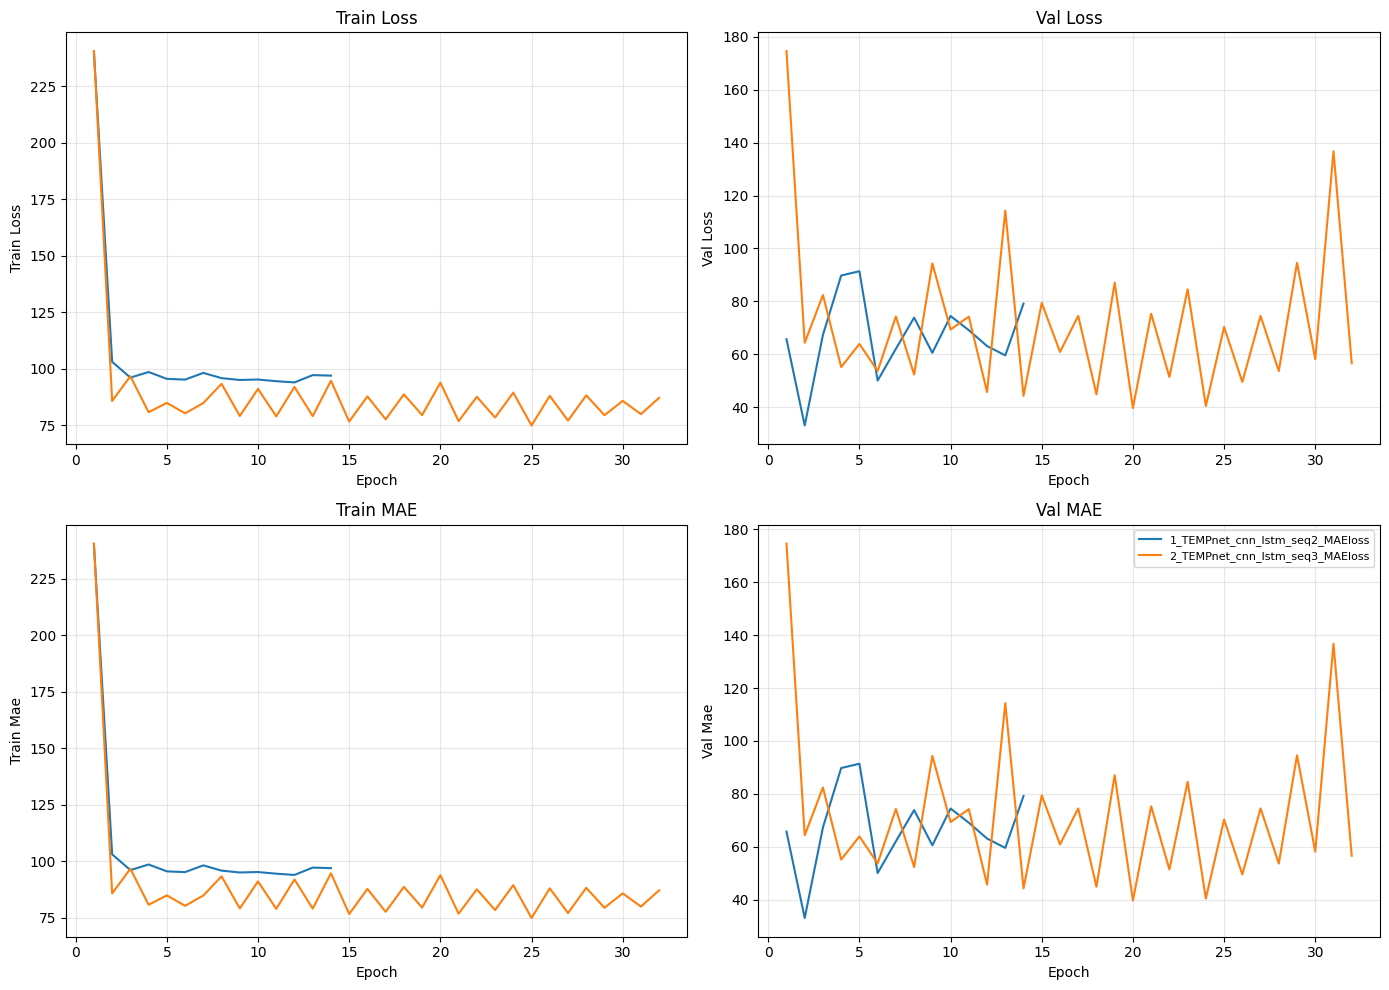

Saved comparison grid to TEMPnet_output/all_models_comparison.png
ID   Name                                               Train        Val   TrainMAE     ValMAE   BestEp    TestMAE
------------------------------------------------------------------------------------------------------------------
1    1_TEMPnet_cnn_lstm_seq2_MAEloss                  96.9083    79.1788    96.9083    79.1788        2    38.7203
2    2_TEMPnet_cnn_lstm_seq3_MAEloss                  87.1132    56.6065    87.1132    56.6065       20    47.4266
Pipeline complete.


In [6]:
def train_tempnet_model(config: Dict, force_retrain: bool = False) -> Dict:
    seq_length = config["seq_length"]
    run_dir = OUTPUT_ROOT / config["name"]
    checkpoint_dir = run_dir / "checkpoints"
    history_path = run_dir / "history.json"
    config_path = run_dir / "config.json"
    test_path = run_dir / "test_results.json"
    best_ckpt = checkpoint_dir / "best_model.pt"

    run_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_dir.mkdir(parents=True, exist_ok=True)

    if not force_retrain and best_ckpt.exists() and history_path.exists():
        print(f"✓ {config['name']} already trained. Loading cached artifacts.")
        history = load_json_if_exists(history_path)
        test_metrics = load_json_if_exists(test_path)
        metadata = load_json_if_exists(config_path).get("dataset", {})
        return {
            "status": "cached",
            "history": history,
            "run_dir": run_dir,
            "seq_length": seq_length,
            "best_epoch": history.get("best_epoch"),
            "test_metrics": test_metrics,
            "dataset": metadata,
        }

    train_loader, val_loader, test_loader, dataset_meta = build_dataloaders(seq_length)

    model = CNN_LSTM(lstm_layers=config.get("lstm_layers", 2)).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.L1Loss()

    history = {"train_loss": [], "val_loss": [], "train_mae": [], "val_mae": [], "best_epoch": None}
    best_val_loss = float("inf")
    best_epoch = 0
    epochs_without_improvement = 0

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        running_mae = 0.0
        samples = 0

        for batch in tqdm(train_loader, desc=f"Seq{seq_length} Epoch {epoch}/{EPOCHS} [train]", leave=False):
            context = batch["context"].float().to(DEVICE)
            target = batch["target"].float().to(DEVICE)
            mask = batch["target_mask"].to(DEVICE).unsqueeze(1).bool()

            optimizer.zero_grad()
            prediction = model(context)

            if mask.sum() == 0:
                continue

            masked_pred = prediction[mask]
            masked_target = target[mask]
            loss = criterion(masked_pred, masked_target)
            loss.backward()
            optimizer.step()

            batch_mae = torch.mean(torch.abs(masked_pred - masked_target))
            batch_size = context.size(0)
            running_loss += loss.item() * batch_size
            running_mae += batch_mae.item() * batch_size
            samples += batch_size

        avg_train_loss = running_loss / max(samples, 1)
        avg_train_mae = running_mae / max(samples, 1)

        val_metrics = evaluate_split(model, val_loader, criterion)
        avg_val_loss = val_metrics["loss"]
        avg_val_mae = val_metrics["mae"]

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_mae"].append(avg_train_mae)
        history["val_mae"].append(avg_val_mae)

        print(
            f"Epoch {epoch:03d} | train={avg_train_loss:.4f} | val={avg_val_loss:.4f} | "
            f"train_mae={avg_train_mae:.4f} | val_mae={avg_val_mae:.4f}"
        )

        if avg_val_loss + MIN_DELTA < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            epochs_without_improvement = 0
            torch.save({"model_state_dict": model.state_dict(), "epoch": epoch}, best_ckpt)
            print("  → New best checkpoint saved")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= PATIENCE:
                print("  → Early stopping triggered")
                break

    history["best_epoch"] = best_epoch

    if best_ckpt.exists():
        ckpt = torch.load(best_ckpt, map_location=DEVICE)
        model.load_state_dict(ckpt["model_state_dict"])

    test_metrics = evaluate_split(model, test_loader, criterion)

    config_payload = {
        "model": {
            "name": "CNN_LSTM",
            "parameters": model.count_parameters(),
            "sequence_length": seq_length,
            "lstm_layers": config.get("lstm_layers", 2),
        },
        "training": {
            "epochs": len(history["train_loss"]),
            "patience": PATIENCE,
            "learning_rate": LEARNING_RATE,
            "batch_size": BATCH_SIZE,
        },
        "dataset": dataset_meta,
    }

    save_json(history_path, history)
    save_json(config_path, config_payload)
    save_json(test_path, test_metrics)

    plot_path = run_dir / "training_losses.png"
    plot_losses({"train_loss": history["train_loss"], "val_loss": history["val_loss"]}, str(plot_path))

    return {
        "status": "trained",
        "history": history,
        "run_dir": run_dir,
        "seq_length": seq_length,
        "best_epoch": best_epoch,
        "test_metrics": test_metrics,
        "dataset": dataset_meta,
    }


def run_all_experiments(force_retrain: bool = False) -> Dict[str, Dict]:
    results: Dict[str, Dict] = {}
    for cfg in MODEL_CONFIGS:
        print(f"\n=== Running {cfg['name']} (seq_len={cfg['seq_length']}) ===")
        result = train_tempnet_model(cfg, force_retrain=force_retrain)
        results[cfg["name"]] = result

    json_payload = {
        name: {
            "seq_length": res.get("seq_length"),
            "best_epoch": res.get("best_epoch"),
            "status": res.get("status"),
            "test_metrics": res.get("test_metrics"),
        }
        for name, res in results.items()
    }
    summary_path = OUTPUT_ROOT / "experiment_results.json"
    save_json(summary_path, json_payload)
    print(f"Saved aggregate results to {summary_path}")
    return results


def load_best_model(run_dir: Path, lstm_layers: int) -> CNN_LSTM:
    model = CNN_LSTM(lstm_layers=lstm_layers).to(DEVICE)
    ckpt_path = run_dir / "checkpoints" / "best_model.pt"
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Missing checkpoint at {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    return model


def generate_prediction_visual(config: Dict, run_dir: Path, sample_idx: int = 0) -> Optional[Path]:
    try:
        model = load_best_model(run_dir, config.get("lstm_layers", 2))
    except FileNotFoundError as exc:
        print(exc)
        return None

    _, _, test_loader, _ = build_dataloaders(config["seq_length"])
    batch = next(iter(test_loader))
    context = batch["context"].float().to(DEVICE)
    target = batch["target"].float().to(DEVICE)

    with torch.no_grad():
        prediction = model(context)

    save_path = run_dir / f"prediction_sample_{sample_idx}.png"
    visualize_prediction(context.cpu(), target.cpu(), prediction.cpu(), save_path=str(save_path), sample_idx=sample_idx)
    return save_path


def plot_comparison_grid(results: Dict[str, Dict]) -> Optional[Path]:
    if not results:
        print("No results to compare yet.")
        return None

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics = ["train_loss", "val_loss", "train_mae", "val_mae"]
    titles = ["Train Loss", "Val Loss", "Train MAE", "Val MAE"]

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        for cfg in MODEL_CONFIGS:
            history = results.get(cfg["name"], {}).get("history", {})
            values = history.get(metric, [])
            if values:
                ax.plot(range(1, len(values) + 1), values, label=cfg["name"])
        ax.set_title(titles[idx])
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.grid(True, alpha=0.3)

    axes[1, 1].legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    comparison_path = OUTPUT_ROOT / "all_models_comparison.png"
    plt.savefig(comparison_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved comparison grid to {comparison_path}")
    return comparison_path


def print_summary_table(results: Dict[str, Dict]) -> None:
    if not results:
        print("No experiment runs recorded.")
        return

    def fmt(value: Optional[float]) -> str:
        return f"{value:.4f}" if isinstance(value, (int, float)) else "N/A"

    header = f"{'ID':<4} {'Name':<45} {'Train':>10} {'Val':>10} {'TrainMAE':>10} {'ValMAE':>10} {'BestEp':>8} {'TestMAE':>10}"
    print("".ljust(len(header), "="))
    print(header)
    print("".ljust(len(header), "-"))

    for cfg in MODEL_CONFIGS:
        res = results.get(cfg["name"], {})
        history = res.get("history", {})
        train = history.get("train_loss", [])
        val = history.get("val_loss", [])
        train_mae = history.get("train_mae", [])
        val_mae = history.get("val_mae", [])
        best_epoch = res.get("best_epoch") or history.get("best_epoch")
        test_mae = (res.get("test_metrics") or {}).get("mae")

        line = (
            f"{cfg['id']:<4} {cfg['name']:<45} "
            f"{fmt(train[-1] if train else None):>10} {fmt(val[-1] if val else None):>10} "
            f"{fmt(train_mae[-1] if train_mae else None):>10} {fmt(val_mae[-1] if val_mae else None):>10} "
            f"{best_epoch if best_epoch else 'N/A':>8} {fmt(test_mae):>10}"
        )
        print(line)

    print("".ljust(len(header), "="))


def run_full_pipeline(force_retrain: bool = False, create_visuals: bool = False, sample_idx: int = 0) -> Dict[str, Dict]:
    results = run_all_experiments(force_retrain=force_retrain)
    plot_comparison_grid(results)
    print_summary_table(results)

    if create_visuals:
        for cfg in MODEL_CONFIGS:
            run_dir = OUTPUT_ROOT / cfg["name"]
            if (run_dir / "checkpoints" / "best_model.pt").exists():
                generate_prediction_visual(cfg, run_dir, sample_idx=sample_idx)

    return results


FORCE_RETRAIN = False  # Set True to ignore cached runs
CREATE_VISUALS = False  # Enable to dump per-model prediction figures
EXPERIMENT_RESULTS = run_full_pipeline(force_retrain=FORCE_RETRAIN, create_visuals=CREATE_VISUALS)
print("Pipeline complete.")